<a id='top'></a>

# Academic Mastery Study

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

## THE DATA
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data).
```python
category_labels.csv
test.csv
training.csv
```
**Test** data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding *users who answered at least 6 questions*, taking **one** of their answers (uniformly random, *from their 6th question to their last*), and inserting it into the **test set**.
* Any *later answers by this user* are removed, 
* and any *earlier answers are included in the **training set***.  
* All answers *from users not in the test set are also used for the training set* (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

---

**`correct`: `0` or `1` [[TARGET]](#target) - indicates whether the student answered the question correctly.** Rename to **`outcome`** during 'data cleaning'.

**`user_id`**: [[**categorical**]](#user_id) - anonymized numeric identifier for the user answering the question.
       
**`question_id`**: [[**categorical**]](#question_id) - a numeric identifier for the question being answered.
     
**`question_type`**: [[**categorical**]](#question_type) - a numeric code representing the type of question; either `MultipleChoiceOneCorrect` (`0`) for multiple choice, or `SPR` (`1`) for free response questions.
   
**`group_name`**: [[**categorical**]](#group_name) - a numeric code representing the test group for this question `{'act':0, 'gmat':1, 'sat':2}`.

`group_name`

     track_name   
        
        subtrack_name
    
            tag_string

**`track_name`**: [[**categorical**]](#track_name) - the numeric code for the track within the test group for this question (mappings from category fields to numeric values are in `category_labels.csv`).

**`subtrack_name`**: [[**categorical**]](#subtrack_name) - the numeric code for the subtrack within the track for this question (mappings from category fields to numeric values are in category_labels.csv).

**`tag_string`**: [[**categorical**]](#tag_string) - a space-separated list of tag ids for this question (mappings from category fields to numeric values are in category_labels.csv).

**`round_started_at`**: [[**numeric**]](#round_started_at) [use this as reference date] - a UTC timestamp indicating when the question was available to the user.

**`answered_at`**: [[**numeric**]](#answered_at) [minutes from reference date] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

**`deactivated_at`**: [[**numeric**]](#deactivated_at) [minutes from reference date] - a UTC timestamp indicating when the round finished, either because the user answered or the questioned timed-out.

**`game_type`**: [[**categorical**]](#game_type) - indicates the type of game/study session (mappings from category fields to numeric values are in category_labels.csv). More information on each of these is provided in the relevant section of this document.

**`num_players`**: [[**numeric**]](#num_players) - the number of players in the game at the time (multiple users can be viewing the same question simultaneously).

**`date_of_test`**: [numeric] [minutes from reference date] - the date the user entered as their expected test date (if entered). Eliminated during 'data cleaning'.

## DATA WRANGLING
---
Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables and organize dataframe. Rectify missing, invalid or corrupted values.

### Import Packages & Training Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

In [2]:
# Download grockit_all_data.zip from https://www.kaggle.com/c/WhatDoYouKnow/data,
# and save in the project's raw data directory.

# Read and save CSV file as dataframe:
df = pd.read_csv('../data/raw/training.csv') 

### Inspect Raw Data

In [3]:
# Inspect the current state of the dataset:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 17 columns):
correct             int64
outcome             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
answer_id           int64
game_type           int64
num_players         int64
date_of_test        object
question_set_id     int64
dtypes: int64(12), object(5)
memory usage: 629.2+ MB


The raw training dataset contains 17 variables (columns) and 4851475 observations (rows/entries).

In [4]:
# Inspect the structure and first 5 observations of the raw dataset:
df.head()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318


In [5]:
# Inspect the last 5 observations:
df.tail()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaN,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaN,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaN,2010-04-19 23:14:35,25553,7,5,NaN,470
4851474,0,4,52513,1272,0,2,7,13,239 245,2010-05-18 14:32:59,NaN,2010-05-18 14:35:15,25553,7,1,NaN,3676


Variables can be eliminated. Rows could be indexed and columns could be ordered more appropriately. Some of the date/time observations contain null values.

### Re-Organize Columns

Some columns, such as those not included in the test dataset, can be removed. MultiIndexing by user and start time seems appropriate. Re-ordering the remaining columns becomes necessary. Once the `outcome` column is eliminated, the `correct` column could be renamed to 'outcome', as it is more semantic. New columns, `round_ended_at` and `round_length`, should be added to hold values for later manipulation and calculation. First, all relevant columns need to be converted to datetime series.

In [6]:
# The first call to convert columns to datetime returned: `ValueError: year 0 is out of range`,
# so this needs to be addressed first. 

# Set up filters and store in variables:
round_started_filter = df['round_started_at'] == '0000-00-00 00:00:00'
answered_at_filter = df['answered_at'] == '0000-00-00 00:00:00'
deactivated_at_filter = df['deactivated_at'] == '0000-00-00 00:00:00'

# Combine filters to apply to the entire dataframe, and inspect the results:
year0_filter = round_started_filter & answered_at_filter & deactivated_at_filter
df[year0_filter]

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
502701,0,2,56022,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22881,10,1,NaN,306
502702,0,2,56022,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22891,10,1,NaN,307
560170,1,1,76463,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22884,10,1,NaN,306
560171,0,2,76463,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,20148,10,1,NaN,307
560172,1,1,76463,225,0,2,6,7,5 131 138,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2874,10,1,NaN,873
560173,1,1,76463,5277,0,2,6,7,1 5 108 131 269 279,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2452,10,1,NaN,788
565302,0,2,13469,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22883,10,1,NaN,306
565303,0,2,13469,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,20148,10,1,NaN,307
565304,1,1,13469,225,0,2,6,7,5 131 138,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2874,10,1,NaN,873
902333,0,2,75026,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22883,10,1,NaN,306


There are 69 observations with no date/time info entered. The most noticeable pattern is that they all involve `game_type` 10 (StudyHallGame), described in the data documentation as "the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions." There are only 2698 observations of this game type in the dataset.

Nonetheless, time data is an important factor in improving the efficiency of testing applications, so dropping the relatively few records with missing data seems appropriate.

In [7]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[year0_filter].index)

In [8]:
# Convert date strings to datetime objects:
df['round_started_at'] = pd.to_datetime(df['round_started_at'])

Trying to convert all three date/time columns resulted in the same error as before. All 69 records eliminated above are the only ones with no time data for `round_started_at`, so that column was converted successfully. The other date/time columns are addressed under the NULL assessment later.

In [9]:
# Drop selected columns and save results:
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')

# Change the name of 'correct' column to outcome:
df = df.rename(columns = {'correct':'outcome'})

# Create new columns, round_ended_at and round_length:
df['round_ended_at'] = ''
df['round_duration'] = ''

# Index the dataset by users, then start time; sort and save:
df = df.set_index(['user_id', 'round_started_at']).sort_index()

In [10]:
# Create and save list of columns to convert to categorical data type:
category_columns = ['group_name', 'track_name', 'subtrack_name', 'question_id', 'question_type', 'game_type']

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    df[column] = df[column].astype('category')

In [11]:
# Inspect the restructured state of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851406 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 14 columns):
outcome           int64
question_id       category
question_type     category
group_name        category
track_name        category
subtrack_name     category
tag_string        object
answered_at       object
deactivated_at    object
game_type         category
num_players       int64
date_of_test      object
round_ended_at    object
round_duration    object
dtypes: category(6), int64(2), object(6)
memory usage: 399.1+ MB


The dataframe is now a MultiIndex of users for whom observations are ordered by start time. Since two of the original (raw dataset) columns are now the part of the index, 3 columns were dropped, and 2 new columns created, there are now 14 data columns, 6 of which are categorical data types.

In [12]:
# Inspect the structure of the new dataframe:
df.head() 

outcome question_id question_type group_name  \
user_id round_started_at                                                    
0       2011-08-26 16:54:31        1        5937             0          0   
        2011-08-26 16:56:12        1         294             0          0   
        2011-08-26 16:56:39        0        5625             0          0   
        2011-08-26 16:57:05        1        4322             0          0   
        2011-08-26 16:57:29        1        5024             0          0   

                            track_name subtrack_name       tag_string  \
user_id round_started_at                                                
0       2011-08-26 16:54:31          2            10   17 122 171 206   
        2011-08-26 16:56:12          2            10    0 100 171 206   
        2011-08-26 16:56:39          2            10   40 124 171 206   
        2011-08-26 16:57:05          2            10   18 139 171 206   
        2011-08-26 16:57:29          2            10  104 127 171 206   

                                     answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   

                            game_type  num_players date_of_test  \
user_id round_started_at                                          
0       2011-08-26 16:54:31         7            1          NaN   
        2011-08-26 16:56:12         7            1          NaN   
        2011-08-26 16:56:39         7            1          NaN   
        2011-08-26 16:57:05         7            1          NaN   
        2011-08-26 16:57:29         7            1          NaN   

                            round_ended_at round_duration  
user_id round_started_at                                   
0       2011-08-26 16:54:31                                
        2011-08-26 16:56:12                                
        2011-08-26 16:56:39                                
        2011-08-26 16:57:05                                
        2011-08-26 16:57:29

In [13]:
# Reorder the columns and save:
column_labels = ['answered_at', 'deactivated_at', 'round_ended_at', 'round_duration', 'outcome', 
                 'group_name', 'track_name', 'subtrack_name', 'tag_string', 'question_id', 
                 'question_type', 'game_type', 'num_players', 'date_of_test']
df = df[column_labels]

# Reinspect the structure to confirm:
df.head(10)

answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   
        2011-08-26 16:57:58  2011-08-26 16:58:17  2011-08-26 16:58:18   
        2011-08-26 16:58:22  2011-08-26 16:58:35  2011-08-26 16:58:41   
1       2011-02-14 07:34:34                  NaN  2011-02-14 07:37:04   
        2011-02-14 07:37:06  2011-02-14 07:38:06  2011-02-14 07:38:06   
        2011-02-14 07:38:08  2011-02-14 07:40:23  2011-02-14 07:40:23   

                            round_ended_at round_duration  outcome group_name  \
user_id round_started_at                                                        
0       2011-08-26 16:54:31                                      1          0   
        2011-08-26 16:56:12                                      1          0   
        2011-08-26 16:56:39                                      0          0   
        2011-08-26 16:57:05                                      1          0   
        2011-08-26 16:57:29                                      1          0   
        2011-08-26 16:57:58                                      0          0   
        2011-08-26 16:58:22                                      1          0   
1       2011-02-14 07:34:34                                      0          1   
        2011-02-14 07:37:06                                      0          1   
        2011-02-14 07:38:08                                      0          1   

                            track_name subtrack_name       tag_string  \
user_id round_started_at                                                
0       2011-08-26 16:54:31          2            10   17 122 171 206   
        2011-08-26 16:56:12          2            10    0 100 171 206   
        2011-08-26 16:56:39          2            10   40 124 171 206   
        2011-08-26 16:57:05          2            10   18 139 171 206   
        2011-08-26 16:57:29          2            10  104 127 171 206   
        2011-08-26 16:57:58          2            10  100 124 171 206   
        2011-08-26 16:58:22          2            10   62 127 171 206   
1       2011-02-14 07:34:34          4             9     4 77 161 251   
        2011-02-14 07:37:06          4             9    14 74 135 161   
        2011-02-14 07:38:08          4             9  14 68 71 77 161   

                            question_id question_type game_type  num_players  \
user_id round_started_at                                                       
0       2011-08-26 16:54:31        5937             0         7            1   
        2011-08-26 16:56:12         294             0         7            1   
        2011-08-26 16:56:39        5625             0         7            1   
        2011-08-26 16:57:05        4322             0         7            1   
        2011-08-26 16:57:29        5024             0         7            1   
        2011-08-26 16:57:58        1233             0         7            1   
        2011-08-26 16:58:22        2546             0         7            1   
1       2011-02-14 07:34:34        4952             0         2            1   
        2011-02-14 07:37:06        1856             0         2            1   
        2011-02-14 07:38:08        4103             0         2            1   

                            date_of_test  
user_id round_started_at                  
0       2011-08-26 16:54:31          NaN  
        2011-08-26 16:56:12          NaN  
        2011-08-26 16:56:39          NaN  
        2011-08-26 16:57:05          NaN  
        2011-08-26 16:57:29          NaN  
        2011-08-26 16:57:58          NaN  
     

### Assess & Handle Possible Duplicate Records

Duplicate user_id records were addressed by MultiIndexing with start times earlier.

### Assess & Handle Missing Data

In [14]:
# Get a null count for each column in the dataframe:
df.isnull().sum() 

answered_at        556018
deactivated_at         30
round_ended_at          0
round_duration          0
outcome                 0
group_name              0
track_name              0
subtrack_name           0
tag_string              0
question_id             0
question_type           0
game_type               0
num_players             0
date_of_test      3824139
dtype: int64

According to information provided with the datasets for this project, `date_of_test` is the date the user entered as their expected test date (**if entered**). Nearly 80% of these values are NULL, but that does not indicate how many users are associated with 'no date entered'. This is explored below.

The information also indicates that missing values from the `answered_at` column are NULL if not answered, so NULL in this case seems to be valuable information.

The NULL count for `deactivated_at` is a bit of a mystery and is examined first.

In [15]:
# Create the filter for NULL values in the deactivated_at column:
null_deactivated_filter = df.deactivated_at.isnull()

# Apply the filter to the dataframe and inspect:
df[null_deactivated_filter]

,,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
user_id,round_started_at,,,,,,,,,,,,,,
21595,2009-04-20 21:17:58,NaN,NaN,,,0,1,4,1,14 52 77 160 279,4494,0,7,5,NaN
33450,2009-02-20 17:55:30,NaN,NaN,,,0,1,5,14,233 240 246,4632,0,7,1,NaN
35763,2009-04-21 06:26:50,2009-04-21 06:27:44,NaN,,,0,1,4,9,14 55 77 135 161,4723,0,7,2,2009-07-17
48073,2009-06-24 15:00:43,2009-06-24 15:02:11,NaN,,,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN
51708,2008-12-24 20:20:17,NaN,NaN,,,0,1,5,11,193 207,4371,0,7,1,NaN
55785,2008-11-13 18:34:55,NaN,NaN,,,0,1,5,14,220 224 227 228 246,2734,0,7,4,NaN
57882,2008-10-21 02:43:55,NaN,NaN,,,0,1,4,9,14 113 161 250 279,5311,0,7,1,NaN
61332,2009-04-20 21:17:58,NaN,NaN,,,0,1,4,1,14 52 77 160 279,4494,0,7,5,2009-07-24
62107,2009-06-24 15:00:43,2009-06-24 15:03:18,NaN,,,0,2,6,15,15 137 204 261 279,4802,1,7,5,2009-12-05


Of the 30 NULL observations for `deactivated_at`, all of them were marked incorrect and all of them are for the game type 7, which is described as "the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question."

Again, time is important information in this study. Observations above with a date/time entered for `answered_at` provide the necessary information and should remain - the NULL values for `deactivated_at` in those rows can be filled or ignored. Since the observations with NULL values for both columns are not useful, they are dropped.

In [16]:
# Drop all rows with NULL values for both answered_at and deactivated_at, save the rest:
df = df.dropna(subset=['answered_at', 'deactivated_at'], how='all') 

# Create new filter for NULL values in the deactivated_at column:
null_deactivated = df.deactivated_at.isnull()

# Confirm the remaining values for deactivated_at:
df[null_deactivated]

answered_at deactivated_at  \
user_id round_started_at                                          
35763   2009-04-21 06:26:50  2009-04-21 06:27:44            NaN   
48073   2009-06-24 15:00:43  2009-06-24 15:02:11            NaN   
62107   2009-06-24 15:00:43  2009-06-24 15:03:18            NaN   
        2009-06-24 15:14:55  2009-06-24 15:16:17            NaN   
65358   2009-06-24 15:00:43  2009-06-24 15:01:58            NaN   
79815   2009-05-17 18:45:38  2009-05-17 18:46:40            NaN   
97518   2009-06-29 15:19:56  2009-06-29 15:21:57            NaN   
107154  2009-04-15 22:33:50  2009-04-15 22:34:29            NaN   
122692  2009-06-25 17:35:54  2009-06-25 17:37:24            NaN   
135617  2009-04-29 16:44:09  2009-04-29 16:45:49            NaN   

                            round_ended_at round_duration  outcome group_name  \
user_id round_started_at                                                        
35763   2009-04-21 06:26:50                                      0          1   
48073   2009-06-24 15:00:43                                      0          2   
62107   2009-06-24 15:00:43                                      0          2   
        2009-06-24 15:14:55                                      0          2   
65358   2009-06-24 15:00:43                                      0          2   
79815   2009-05-17 18:45:38                                      0          1   
97518   2009-06-29 15:19:56                                      0          2   
107154  2009-04-15 22:33:50                                      0          2   
122692  2009-06-25 17:35:54                                      0          2   
135617  2009-04-29 16:44:09                                      0          2   

                            track_name subtrack_name           tag_string  \
user_id round_started_at                                                    
35763   2009-04-21 06:26:50          4             9     14 55 77 135 161   
48073   2009-06-24 15:00:43          6            15   15 137 204 261 279   
62107   2009-06-24 15:00:43          6            15   15 137 204 261 279   
        2009-06-24 15:14:55          6            15   15 137 204 261 279   
65358   2009-06-24 15:00:43          6            15   15 137 204 261 279   
79815   2009-05-17 18:45:38          5            14  220 224 227 228 246   
97518   2009-06-29 15:19:56          6            15   15 137 204 261 279   
107154  2009-04-15 22:33:50          6            15   78 137 147 261 279   
122692  2009-06-25 17:35:54          6            15   15 137 204 261 279   
135617  2009-04-29 16:44:09          6            15            5 138 261   

                            question_id question_type game_type  num_players  \
user_id round_started_at                                                       
35763   2009-04-21 06:26:50        4723             0         7            2   
48073   2009-06-24 15:00:43        4802             1         7            5   
62107   2009-06-24 15:00:43        4802             1         7            5   
        2009-06-24 15:14:55        4802             1         7            5   
65358   2009-06-24 15:00:43        4802             1         7            5   
79815   2009-05-17 18:45:38        2734             0         7            3   
97518   2009-06-29 15:19:56        4802             1         7            5   
107154  2009-04-15 22:33:50        2316             1         7            5   
122692  2009-06-25 17:35:54        4802             1         7            3   
135617  2009-04-29 16:44:09        2096             1         7            2   

                            date_of_test  
user_id round_started_at                  
35763   2009-04-21 06:26:50   2009-07-17  
48073   2009-06-24 15:00:43          NaN  
62107   2009-06-24 15:00:43   2009-12-05  
        2009-06-24 15:14:55   2009-12-05  
65358   2009-06-24 15:00:43          NaN  
79815   2009-05-17 18:45:38          NaN  
97518   2009-06-29 15:19:56  

In [17]:
# Get the number of users remaining after dropping observations:
len(df.reset_index().groupby('user_id').nunique())

179093

In [18]:
# Get the number of users who entered a value for date_of_test:
len(df[df.date_of_test.notnull()].groupby('user_id').sum())

22534

In [19]:
# Get the number of users who did not enter a value for date_of_test:
len(df[df.date_of_test.isnull()].groupby('user_id').sum())

156559

Only 22,534 of the 179,093 users provided an expected test date. Given that nearly 90% of the users did not provide a date, this column will not be analyzed.

In [20]:
# Drop selected columns and save results:
df = df.drop('date_of_test', axis='columns')

In [21]:
# Get a new null count for each column in the dataframe:
df.isnull().sum() 

answered_at       555998
deactivated_at        10
round_ended_at         0
round_duration         0
outcome                0
group_name             0
track_name             0
subtrack_name          0
tag_string             0
question_id            0
question_type          0
game_type              0
num_players            0
dtype: int64

This is expected and useful.

---
**Reminder to Self**: Noticed in game_type notes below and need to address this: "NULL: 6 - values represent a data collection failure." So, NULL counts are not showing up for the game_type column because they are represented by 6.

### Resolve Earlier NULL Related Issues

In [22]:
# Convert date strings to datetime objects; need to ‘coerce’ errors, 
# since there are NULLs that will remain in these columns:
df['answered_at'] = pd.to_datetime(df['answered_at'], errors='coerce') 
df['deactivated_at'] = pd.to_datetime(df['deactivated_at'], errors='coerce')
df['round_ended_at'] = pd.to_datetime(df['round_ended_at'], errors='coerce')
df['round_duration'] = pd.to_datetime(df['round_duration'], errors='coerce')

### One More Tweak Before Exploration

In [23]:
# Split the space delimited tag_string into a list of tag_ids
df['tag_string'] = df.tag_string.str.split(' ')

# Change the name of 'tag_string' column to tag_ids:
df = df.rename(columns = {'tag_string':'tag_ids'})

# Confirm the changes:
df.tag_ids.head()

user_id  round_started_at   
0        2011-08-26 16:54:31     [17, 122, 171, 206]
         2011-08-26 16:56:12      [0, 100, 171, 206]
         2011-08-26 16:56:39     [40, 124, 171, 206]
         2011-08-26 16:57:05     [18, 139, 171, 206]
         2011-08-26 16:57:29    [104, 127, 171, 206]
Name: tag_ids, dtype: object

In [24]:
# Re-inspect the state and structure of the dataframe:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851386 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 13 columns):
answered_at       datetime64[ns]
deactivated_at    datetime64[ns]
round_ended_at    datetime64[ns]
round_duration    datetime64[ns]
outcome           int64
group_name        category
track_name        category
subtrack_name     category
tag_ids           object
question_id       category
question_type     category
game_type         category
num_players       int64
dtypes: category(6), datetime64[ns](4), int64(2), object(1)
memory usage: 362.1+ MB
None


answered_at      deactivated_at  \
user_id round_started_at                                              
0       2011-08-26 16:54:31 2011-08-26 16:55:51 2011-08-26 16:55:53   
        2011-08-26 16:56:12 2011-08-26 16:56:31 2011-08-26 16:56:33   
        2011-08-26 16:56:39 2011-08-26 16:56:54 2011-08-26 16:56:55   
        2011-08-26 16:57:05 2011-08-26 16:57:24 2011-08-26 16:57:25   
        2011-08-26 16:57:29 2011-08-26 16:57:51 2011-08-26 16:57:52   

                            round_ended_at round_duration  outcome group_name  \
user_id round_started_at                                                        
0       2011-08-26 16:54:31            NaT            NaT        1          0   
        2011-08-26 16:56:12            NaT            NaT        1          0   
        2011-08-26 16:56:39            NaT            NaT        0          0   
        2011-08-26 16:57:05            NaT            NaT        1          0   
        2011-08-26 16:57:29            NaT            NaT        1          0   

                            track_name subtrack_name               tag_ids  \
user_id round_started_at                                                     
0       2011-08-26 16:54:31          2            10   [17, 122, 171, 206]   
        2011-08-26 16:56:12          2            10    [0, 100, 171, 206]   
        2011-08-26 16:56:39          2            10   [40, 124, 171, 206]   
        2011-08-26 16:57:05          2            10   [18, 139, 171, 206]   
        2011-08-26 16:57:29          2            10  [104, 127, 171, 206]   

                            question_id question_type game_type  num_players  
user_id round_started_at                                                      
0       2011-08-26 16:54:31        5937             0         7            1  
        2011-08-26 16:56:12         294             0         7            1  
        2011-08-26 16:56:39        5625             0         7            1  
        2011-08-26 16:57:05        4322             0         7            1  
        2011-08-26 16:57:29        5024             0         7            1

89 of the original 4,851,475 observations were dropped for unresolvable NULL values, leaving 4,851,386 observations to explore further. The appropriate columns are now datetime objects. Since the last inspection of info, the `date_of_test` column was dropped, leaving 13 columns currently in the dataframe. Memory usage for the dataframe since data import has decreased by 267 MB.

## CATEGORICAL DATA EXPLORATION
---
Inspect variables and analayze outliers. Keep these general questions in mind:

* How many are unique?

* How many users per unique value?

* How many questions per unique value?

* How many are unique per user (`user_id`)? 

* How many are unique per unique question (`question_id`)?

* What are the statistics related to outcome?

In trying to predict whether a user will answer the next test question correctly, this study focuses on the performance of both users and specific questions.

__For Clarification__:
* question = observation (row)
* unique question = `question_id`
* user = `user_id`

<a id='target' href='#top'>back to menu</a>

### Target (`outcome`) Statistics

In [25]:
df.outcome.describe()

count    4.851386e+06
mean     5.474520e-01
std      4.977433e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: outcome, dtype: float64

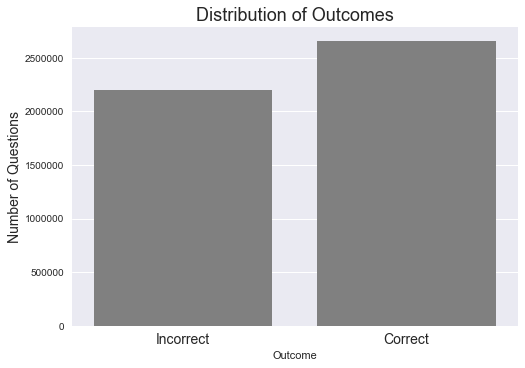

In [26]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x="outcome", color='grey');

# Create bar labels:
plt.xticks(np.arange(2), ('Incorrect', 'Correct'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('Outcome')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Distribution of Outcomes', fontsize=18)

# Display the plot:
plt.show()

### Users and Unique Questions

<a id='user_id' href='#top'>back to menu</a>

#### `user_id`
---

1. How many users?
2. How many questions per user?
3. What are user statistics related to outcome?

In [27]:
# Count the number of unique user_id values:
print( ('Number of Users:'), len(df.reset_index().user_id.value_counts()) ) 

Number of Users: 179093


In [28]:
# Count and save the number of unique users:
questions_per_user = df.reset_index().user_id.value_counts()
print(questions_per_user.head(2))

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
questions_per_user = questions_per_user.to_frame('question_count').reset_index().drop('index', axis='columns')

# Print the first 5 observations and inspect:
questions_per_user.head()

133472    10105
139564     7246
Name: user_id, dtype: int64


,question_count
0,10105
1,7246
2,7147
3,7021
4,6760


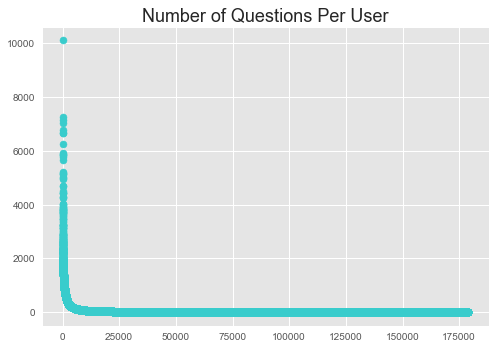

In [29]:
# Set the plot style:
plt.style.use('ggplot')

# Create questions_per_user scatter plot:
plt.scatter(questions_per_user.index, questions_per_user.question_count, color='#39cccc')

# Create the title of the plot:
plt.title('Number of Questions Per User', fontsize=18)

# Set each axis scale and limits:
# plt.yscale('log')
# plt.xlim(0,2000)
# plt.xlim(0,1000)

# Display the plot:
plt.show()

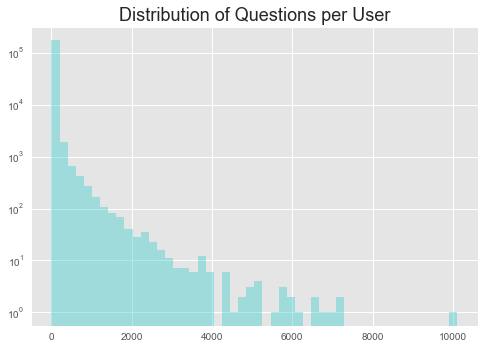

In [30]:
# Create a histogram of questions_per_user:
sns.distplot(questions_per_user, kde=False, color='#39cccc')

# Set each axis scale and limits:
plt.yscale('log')
# plt.xlim(0,8000)

# Create a title:
plt.title('Distribution of Questions per User', fontsize=18)

# Display the plot:
plt.show() 

In [31]:
# Set up some variables to inspect ratios and distributions of correct, incorrect:

# Save the total number of entries per user in the outcome column:
question_count = df.reset_index().groupby('user_id')['outcome'].count()

# Save the total number of correct entries per user in the 'outcome' column;
# values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
correct_answer_count = df.reset_index().groupby('user_id')['outcome'].sum()

# Save the total number of incorrect entries per user by subracting correct from total:
incorrect_answer_count = question_count.subtract(correct_answer_count)

# Save the ratio of correct answers per user, dividing by total:
ratio = correct_answer_count/question_count

# Build and save the dictionary and dataframe to look at user scores:
user_score = {
    'num_questions': question_count,
    'num_correct': correct_answer_count,
    'num_incorrect': incorrect_answer_count,
    'correct_ratio': ratio
}
df_user_score = pd.DataFrame(user_score)

# Rearrange the column order:
df_user_score = df_user_score[['num_correct', 'num_incorrect', 
                               'num_questions', 'correct_ratio']]

# Inspect the structure and values in the first 5 rows of the user score dataframe:
df_user_score.head() 

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
0,5,2,7,0.714286
1,6,8,14,0.428571
2,2,6,8,0.250000
3,3,4,7,0.428571
4,7,4,11,0.636364


In [32]:
df_user_score.describe() 

,num_correct,num_incorrect,num_questions,correct_ratio
count,179093.000000,179093.000000,179093.000000,179093.000000
mean,14.829731,12.258910,27.088641,0.353849
std,92.512169,59.792317,146.185360,0.306896
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000
50%,2.000000,3.000000,6.000000,0.363636
75%,6.000000,7.000000,13.000000,0.600000
max,8018.000000,5383.000000,10105.000000,1.000000


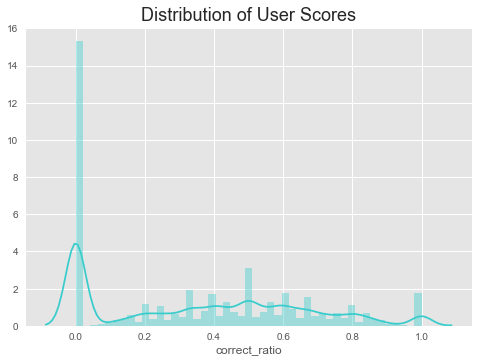

In [33]:
# Create a distribution plot of user scores (correct ratio)
sns.distplot(df_user_score.correct_ratio, color='#39cccc')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show()  

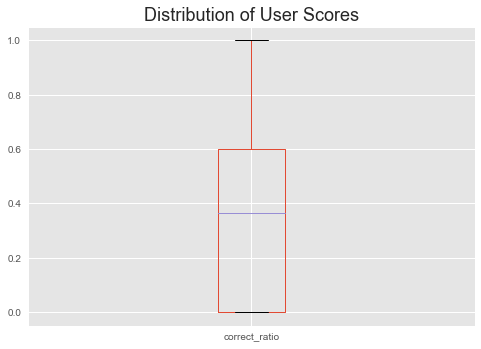

In [34]:
# Create a box plot of the user scores:
df_user_score.boxplot(column='correct_ratio')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show() 

In [35]:
# Inspect distribution of score percentiles:
df_user_score['correct_ratio'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0    0.000000
0.1    0.000000
0.2    0.000000
0.3    0.000000
0.4    0.250000
0.5    0.363636
0.6    0.461538
0.7    0.545455
0.8    0.636364
0.9    0.781250
1.0    1.000000
Name: correct_ratio, dtype: float64

In [36]:
# Number of users with question count == 1


In [37]:
# Number of users with correct ratio == 0


<a id='question_id' href='#top'>back to menu</a>

#### question_id
---

1. How many are unique?
2. How many users per unique question (question_id)?
3. How many questions per question_id?
4. What are the statistics related to outcome?

In [38]:
# Print the number of unique questions in the dataset:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [39]:
# Count and save the number of users per unique question, then inspect:
users_per_questionid = df.reset_index().groupby('question_id').user_id.nunique().sort_values(ascending=False)

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
users_per_questionid = users_per_questionid.to_frame('user_id_count').reset_index().drop('question_id', axis='columns')
users_per_questionid.head()

,user_id_count
0,14063
1,13234
2,10184
3,10158
4,9929


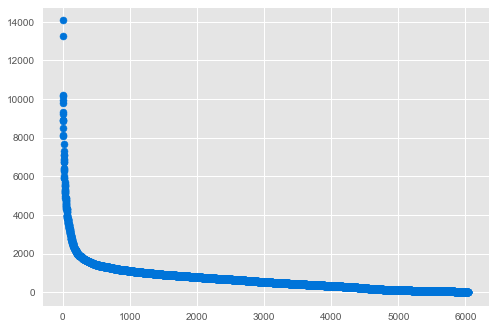

In [40]:
plt.scatter(users_per_questionid.index, users_per_questionid.user_id_count, color='#0074d9') 
plt.show()

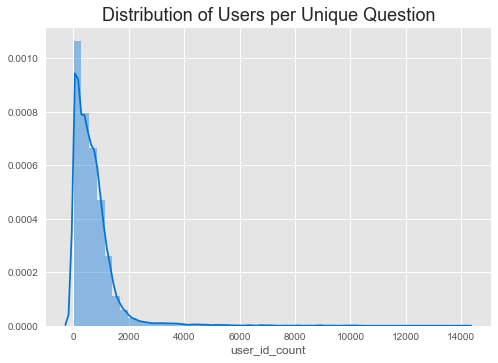

In [41]:
# Create a histogram of users_per_question_id:
sns.distplot(users_per_questionid.user_id_count, color='#0074d9')

# Set each axis scale and limits:
# plt.yscale('log')
# plt.xlim(0,8000)

# Create a title:
plt.title('Distribution of Users per Unique Question', fontsize=18)

# Display the plot:
plt.show()

<a id='group_name' href='#top'>back to menu</a>

#### group_name
---

1. How many are unique?
2. How many users per group_name?
3. How many questions per group_name?
4. How many are unique per user (user_id)?
5. How many are unique per unique question (question_id)?
6. What are the statistics related to outcome?

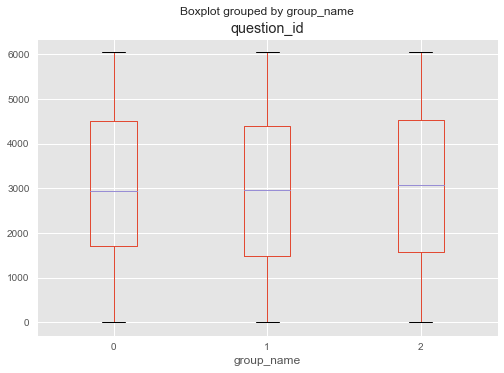

In [42]:
# Create a box plot of question_id by group_name:
df.boxplot(column='question_id', by='group_name')

# Display the plot:
plt.show()

<a id='track_name' href='#top'>back to menu</a>

#### track_name
---

1. How many are unique?
2. How many users per track_name?
3. How many questions per track_name?
4. How many are unique per user (user_id)?
5. How many are unique per unique question (question_id)?
6. What are the statistics related to outcome?

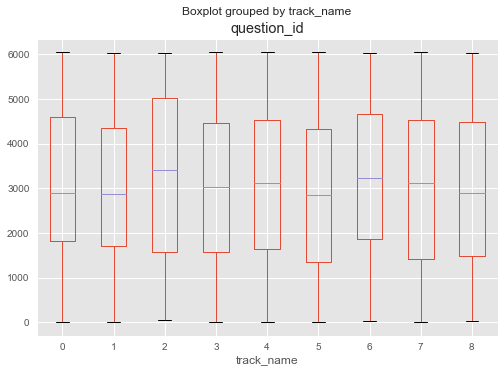

In [43]:
# Create a box plot of question_id by track_name:
df.boxplot(column='question_id', by='track_name')

# Display the plot:
plt.show()

<a id='subtrack_name' href='#top'>back to menu</a>

#### subtrack_name
---

1. How many are unique?
2. How many users per subtrack_name?
3. How many questions per subtrack_name?
4. How many are unique per user (user_id)?
5. How many are unique per unique question (question_id)?
6. What are the statistics related to outcome?

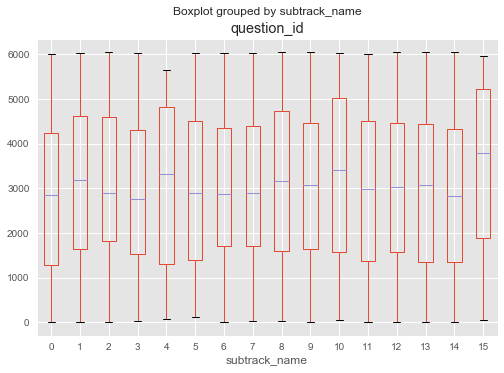

In [44]:
# Create a box plot of question_id by subtrack_name:
df.boxplot(column='question_id', by='subtrack_name')

# Display the plot:
plt.show()

<a id='tag_string' href='#top'>back to menu</a>

#### tag_string
---

<a id='question_type' href='#top'>back to menu</a>

#### question_type
---

1. How many are unique?
2. How many users per question_type?
3. How many questions per question_type?
4. How many are unique per user (user_id)?
5. How many are unique per unique question (question_id)?
6. What are the statistics related to outcome?

In [45]:
# Count the unique values and save, then print:
question_type_count = df.question_type.value_counts()
print(question_type_count) 

0    4666420
1     184966
Name: question_type, dtype: int64


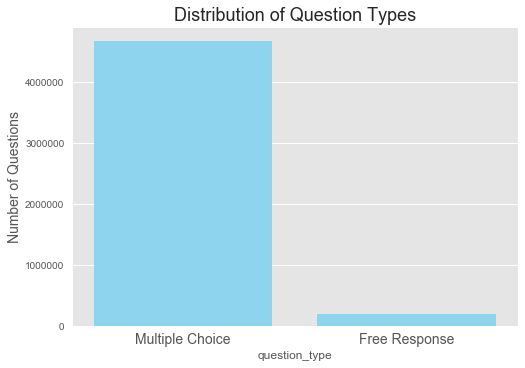

In [46]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='question_type', color='#7fdbff');

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('question_type')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Distribution of Question Types', fontsize=18)

# Display the plot:
plt.show()

<a id='game_type' href='#top'>back to menu</a>

#### game_type
---

**`BookmarkGame: 0`** - values are like `ReviewGames`, but on specific questions the user has bookmarked.

**`ChallengeGame: 1`** - values are solo games where the user is taking a series of questions intended to challenge them and give them the best opportunities for learning.

**`CompetitiveGame: 2`** - values are the most different from other types of games. In these, once one user has answered correctly, the other users should be marked as 'skipped', and the game immediately proceeds to the next question. At the end of the game, whomever has answered the most questions correct wins.

**`ComputerAdaptiveTestGame: 3`** - values are the user answering questions on a full-length CAT, designed to mimic the algorithms used in the actual test, to ask them questions designed to maximize the information gain on the user's ability. TRYING TO IMPROVE THIS.

**`CustomGame: 4`** - values are normal games (like `PracticeGame`), but with some settings (such as specific areas or difficulty levels) chosen by the user.

**`DiagnosticGame: 5`** - values are solo games which are intended to give an initial rough assessment of the user's ability level.

**`NULL: 6`** - values represent a data collection failure.

**`PracticeGame: 7`** - is the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question.  Note that these can be solo games as well.

**`RecitationGame: 8`** - represents a game led by a tutor through a series of questions, with the tutor controlling the pace of advancement.

**`ReviewGame: 9`** - is a solo game (essentially a solo `PracticeGame`) started by a user to review questions they have played in the past.

**`StudyHallGame: 10`** - is the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions.

**`StudyTaskGame: 11`** - is a game where the user is answering questions in a common skill area, in order to achieve a task in their personalized study plan.

1. How many are unique?
2. How many users per game_type?
3. How many questions per game_type?
4. How many are unique per user (user_id)?
5. How many are unique per unique question (question_id)?
6. What are the statistics related to outcome?

In [47]:
# Confirm that there are 12 of game_type:
len( df.game_type.unique() )

12

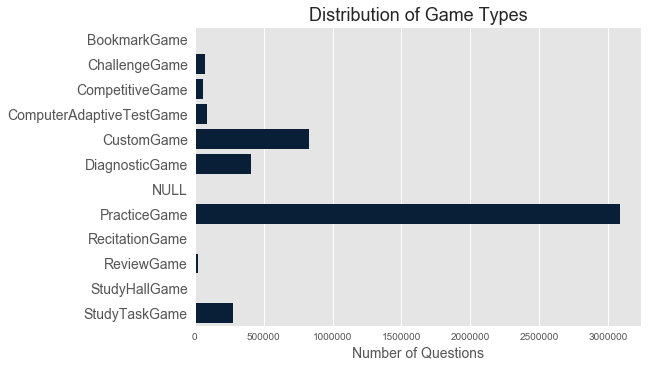

In [48]:
# Create bar plot for game_type distribution:
sns.countplot(data=df, y='game_type', color='#001f3f')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'NULL', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Distribution of Game Types', fontsize=18)

# Display the plot:
plt.show()

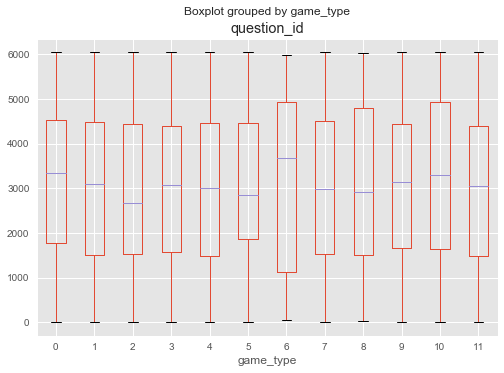

In [49]:
# Create a box plot of question_id by game_type:
df.boxplot(column='question_id', by='game_type')

# Display the plot:
plt.show()

## NUMERICAL DATA EXPLORATION
---

<a id='round_started_at' href='#top'>back to menu</a>

#### round_started_at
---

[use this as reference datetime]

In [50]:
df.reset_index().round_started_at.describe() 

count                 4851386
unique                4195308
top       2010-09-29 18:26:17
freq                       23
first     2008-08-26 18:34:30
last      2011-11-16 08:13:07
Name: round_started_at, dtype: object

<a id='answered_at' href='#top'>back to menu</a>

#### answered_at
---

[minutes from reference datetime]

In [51]:
df.answered_at.describe()

count                 4295387
unique                4145496
top       2011-03-02 13:11:22
freq                        6
first     2008-08-26 18:39:02
last      2011-11-16 08:13:34
Name: answered_at, dtype: object

<a id='deactivated_at' href='#top'>back to menu</a>

#### deactivated_at
---

[minutes from reference datetime]

In [52]:
df.deactivated_at.describe()

count                 4851375
unique                4208539
top       2010-09-29 18:27:26
freq                       22
first     2008-08-26 18:34:57
last      2011-11-16 08:13:35
Name: deactivated_at, dtype: object

<a id='deactivated_at' href='#top'>back to menu</a>

#### round_ended_at
---

[minutes from reference datetime]

In [53]:
df['round_ended_at'] = df['answered_at'].fillna(df['deactivated_at'])
df[df.answered_at.isnull()].head()

answered_at      deactivated_at  \
user_id round_started_at                                      
1       2011-02-14 07:34:34         NaT 2011-02-14 07:37:04   
        2011-02-14 07:41:45         NaT 2011-02-14 07:44:16   
        2011-02-14 07:48:09         NaT 2011-02-14 07:50:40   
        2011-02-14 07:50:42         NaT 2011-02-14 07:53:12   
        2011-02-14 07:53:45         NaT 2011-02-14 07:54:04   

                                 round_ended_at round_duration  outcome  \
user_id round_started_at                                                  
1       2011-02-14 07:34:34 2011-02-14 07:37:04            NaT        0   
        2011-02-14 07:41:45 2011-02-14 07:44:16            NaT        0   
        2011-02-14 07:48:09 2011-02-14 07:50:40            NaT        0   
        2011-02-14 07:50:42 2011-02-14 07:53:12            NaT        0   
        2011-02-14 07:53:45 2011-02-14 07:54:04            NaT        0   

                            group_name track_name subtrack_name  \
user_id round_started_at                                          
1       2011-02-14 07:34:34          1          4             9   
        2011-02-14 07:41:45          1          4             9   
        2011-02-14 07:48:09          1          4             9   
        2011-02-14 07:50:42          1          4             9   
        2011-02-14 07:53:45          1          4             9   

                                            tag_ids question_id question_type  \
user_id round_started_at                                                        
1       2011-02-14 07:34:34       [4, 77, 161, 251]        4952             0   
        2011-02-14 07:41:45       [4, 14, 161, 279]        1976             0   
        2011-02-14 07:48:09      [4, 148, 161, 279]        1080             0   
        2011-02-14 07:50:42  [4, 59, 118, 161, 279]        2065             0   
        2011-02-14 07:53:45   [14, 68, 71, 77, 161]        4103             0   

                            game_type  num_players  
user_id round_started_at                            
1       2011-02-14 07:34:34         2            1  
        2011-02-14 07:41:45         2            1  
        2011-02-14 07:48:09         2            1  
        2011-02-14 07:50:42         2            1  
        2011-02-14 07:53:45         9            1

<a id='deactivated_at' href='#top'>back to menu</a>

#### round_duration
---

[minutes from reference datetime]

<a id='num_players' href='#top'>back to menu</a>

#### num_players
---



<a id='date_of_test' href='#top'>back to menu</a>

## Save Clean DataFrame

In [54]:
# Inspect one more time:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851386 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 13 columns):
answered_at       datetime64[ns]
deactivated_at    datetime64[ns]
round_ended_at    datetime64[ns]
round_duration    datetime64[ns]
outcome           int64
group_name        category
track_name        category
subtrack_name     category
tag_ids           object
question_id       category
question_type     category
game_type         category
num_players       int64
dtypes: category(6), datetime64[ns](4), int64(2), object(1)
memory usage: 527.1+ MB


In [55]:
# Inspect one more time:
df.head()

answered_at      deactivated_at  \
user_id round_started_at                                              
0       2011-08-26 16:54:31 2011-08-26 16:55:51 2011-08-26 16:55:53   
        2011-08-26 16:56:12 2011-08-26 16:56:31 2011-08-26 16:56:33   
        2011-08-26 16:56:39 2011-08-26 16:56:54 2011-08-26 16:56:55   
        2011-08-26 16:57:05 2011-08-26 16:57:24 2011-08-26 16:57:25   
        2011-08-26 16:57:29 2011-08-26 16:57:51 2011-08-26 16:57:52   

                                 round_ended_at round_duration  outcome  \
user_id round_started_at                                                  
0       2011-08-26 16:54:31 2011-08-26 16:55:51            NaT        1   
        2011-08-26 16:56:12 2011-08-26 16:56:31            NaT        1   
        2011-08-26 16:56:39 2011-08-26 16:56:54            NaT        0   
        2011-08-26 16:57:05 2011-08-26 16:57:24            NaT        1   
        2011-08-26 16:57:29 2011-08-26 16:57:51            NaT        1   

                            group_name track_name subtrack_name  \
user_id round_started_at                                          
0       2011-08-26 16:54:31          0          2            10   
        2011-08-26 16:56:12          0          2            10   
        2011-08-26 16:56:39          0          2            10   
        2011-08-26 16:57:05          0          2            10   
        2011-08-26 16:57:29          0          2            10   

                                          tag_ids question_id question_type  \
user_id round_started_at                                                      
0       2011-08-26 16:54:31   [17, 122, 171, 206]        5937             0   
        2011-08-26 16:56:12    [0, 100, 171, 206]         294             0   
        2011-08-26 16:56:39   [40, 124, 171, 206]        5625             0   
        2011-08-26 16:57:05   [18, 139, 171, 206]        4322             0   
        2011-08-26 16:57:29  [104, 127, 171, 206]        5024             0   

                            game_type  num_players  
user_id round_started_at                            
0       2011-08-26 16:54:31         7            1  
        2011-08-26 16:56:12         7            1  
        2011-08-26 16:56:39         7            1  
        2011-08-26 16:57:05         7            1  
        2011-08-26 16:57:29         7            1

In [56]:
# df.to_csv('../data/interim/training_clean.csv')